# **RTMO**

[just_dance source](https://github.com/open-mmlab/mmpose/tree/main/projects/just_dance)

In [4]:
from moviepy.editor import VideoFileClip

def split_video_vertically(input_video_path, output_left_path, output_right_path, start_frame, end_frame):
    # Загружаем видео
    video = VideoFileClip(input_video_path)

    # Получаем количество кадров в секунду
    fps = video.fps

    # Вычисляем временные метки в секундах
    start_time = start_frame / fps
    end_time = end_frame / fps

    # Извлекаем нужный фрагмент видео
    video_segment = video.subclip(start_time, end_time)

    # Получаем ширину и высоту видео
    width, height = video_segment.size

    # Определяем левые и правые половины
    left_half = video_segment.crop(x1=0, y1=0, x2=width // 2, y2=height)
    right_half = video_segment.crop(x1=width // 2, y1=0, x2=width, y2=height)

    # Сохраняем результаты
    left_half.write_videofile(output_left_path, codec='libx264')
    right_half.write_videofile(output_right_path, codec='libx264')

# Пример использования
input_video = "/content/TikTok_Dance.mp4"  # Путь к входному видео
output_left = "/content/left_half.mp4"     # Путь для сохранения левой половины
output_right = "/content/right_half.mp4"   # Путь для сохранения правой половины

# Задаем кадры, которые нужно извлечь
start_frame = 50
end_frame = 366

split_video_vertically(input_video, output_left, output_right, start_frame, end_frame)

  if event.key is 'enter':



Moviepy - Building video /content/left_half.mp4.
MoviePy - Writing audio in left_halfTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/left_half.mp4



Moviepy - Done !
Moviepy - video ready /content/left_half.mp4
Moviepy - Building video /content/right_half.mp4.
MoviePy - Writing audio in right_halfTEMP_MPY_wvf_snd.mp3


MoviePy - Done.
Moviepy - Writing video /content/right_half.mp4



Moviepy - Done !
Moviepy - video ready /content/right_half.mp4


In [2]:
!pip install mmcv==2.1.0 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.4/471.4 kB 7.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.4/45.4 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.3/452.3 kB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.7/254.7 kB 12.2 MB/s eta 0:00:00


In [6]:
!pip install mmpose -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 2.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 436.0/436.0 kB 20.3 MB/s eta 0:00:00


In [7]:
!pip install mmdet -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 31.5 MB/s eta 0:00:00


In [8]:
!mkdir configs
!mv rtmdet-nano_one-person.py configs/

In [9]:
!mv rtmdet_nano_320-8xb32_coco-person.py configs/

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt
import os.path as osp
import torch
import numpy as np
import mmcv
import cv2
from tqdm import tqdm
from mmengine.utils import track_iter_progress

from mmcv import VideoReader

In [5]:
student_video = '/content/left_half.mp4'
teacher_video = '/content/right_half.mp4'

In [11]:
# init pose estimator
from mmpose.apis.inferencers import Pose2DInferencer
pose_estimator = Pose2DInferencer(
    'rtmpose-t_8xb256-420e_aic-coco-256x192',
    det_model='configs/rtmdet-nano_one-person.py',
    det_weights='https://download.openmmlab.com/mmpose/v1/projects/'
    'rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth'
)
pose_estimator.model.test_cfg['flip_test'] = False

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmposev1/rtmpose-tiny_simcc-aic-coco_pt-aic-coco_420e-256x192-cfc8f33d_20230126.pth
Loads checkpoint by http backend from path: https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth


Downloading: "https://download.openmmlab.com/mmpose/v1/projects/rtmpose/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth" to /root/.cache/torch/hub/checkpoints/rtmdet_nano_8xb32-100e_coco-obj365-person-05d8511e.pth


10/20 19:14:39 - mmengine - WARNING - Failed to search registry with scope "mmdet" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmdet" is a correct scope, or whether the registry is initialized.


In [32]:
@torch.no_grad()
def get_keypoints_from_frame(image, pose_estimator):
    """Extract keypoints from a single video frame."""

    det_results = pose_estimator.detector(
        image)['predictions']

    pred_instance = det_results[0]

    if len(pred_instance) == 0 or pred_instance['scores'][0] < 0.2:
        return np.zeros((1, 17, 3), dtype=np.float32)

    data_info = dict(
        img=image,
        bbox=np.array(pred_instance['bboxes'][:1]),
        bbox_score=np.array(pred_instance['scores'][:1])
        )

    data_info.update(pose_estimator.model.dataset_meta)
    data = pose_estimator.collate_fn(
        [pose_estimator.pipeline(data_info)]
        )

    # custom forward
    data = pose_estimator.model.data_preprocessor(data, False)
    feats = pose_estimator.model.extract_feat(data['inputs'])
    pred_instances = pose_estimator.model.head.predict(
        feats,
        data['data_samples'],
        test_cfg=pose_estimator.model.test_cfg)[0]
    keypoints = np.concatenate(
        (pred_instances.keypoints, pred_instances.keypoint_scores[...,
                                                                  None]),
        axis=-1)

    return keypoints

In [33]:
# pose estimation in two videos
student_poses, teacher_poses = [], []
for frame in tqdm(VideoReader(student_video)):
    student_poses.append(get_keypoints_from_frame(frame, pose_estimator))
for frame in tqdm(VideoReader(teacher_video)):
    teacher_poses.append(get_keypoints_from_frame(frame, pose_estimator))

student_poses = np.concatenate(student_poses)
teacher_poses = np.concatenate(teacher_poses)

  0%|          | 0/316 [00:00<?, ?it/s]WARNING:py.warnings:/usr/local/lib/python3.10/dist-packages/mmdet/models/layers/se_layer.py:158: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=False):

  with torch.cuda.amp.autocast(enabled=False):

100%|██████████| 316/316 [00:44<00:00,  7.17it/s]


In [34]:
valid_indices = np.array([0] + list(range(5, 17)))

@torch.no_grad()
def _calculate_similarity(tch_kpts: np.ndarray, stu_kpts: np.ndarray):

    stu_kpts = torch.from_numpy(stu_kpts[:, None, valid_indices])
    tch_kpts = torch.from_numpy(tch_kpts[None, :, valid_indices])
    stu_kpts = stu_kpts.expand(stu_kpts.shape[0], tch_kpts.shape[1],
                               stu_kpts.shape[2], 3)
    tch_kpts = tch_kpts.expand(stu_kpts.shape[0], tch_kpts.shape[1],
                               stu_kpts.shape[2], 3)

    matrix = torch.stack((stu_kpts, tch_kpts), dim=4)
    if torch.cuda.is_available():
        matrix = matrix.cuda()
    # only consider visible keypoints
    mask = torch.logical_and(matrix[:, :, :, 2, 0] > 0.3,
                             matrix[:, :, :, 2, 1] > 0.3)
    matrix[~mask] = 0.0

    matrix_ = matrix.clone()
    matrix_[matrix == 0] = 256
    x_min = matrix_.narrow(3, 0, 1).min(dim=2).values
    y_min = matrix_.narrow(3, 1, 1).min(dim=2).values
    matrix_ = matrix.clone()
    x_max = matrix_.narrow(3, 0, 1).max(dim=2).values
    y_max = matrix_.narrow(3, 1, 1).max(dim=2).values

    matrix_ = matrix.clone()
    matrix_[:, :, :, 0] = (matrix_[:, :, :, 0] - x_min) / (
        x_max - x_min + 1e-4)
    matrix_[:, :, :, 1] = (matrix_[:, :, :, 1] - y_min) / (
        y_max - y_min + 1e-4)
    matrix_[:, :, :, 2] = (matrix_[:, :, :, 2] > 0.3).float()
    xy_dist = matrix_[..., :2, 0] - matrix_[..., :2, 1]
    score = matrix_[..., 2, 0] * matrix_[..., 2, 1]

    similarity = (torch.exp(-50 * xy_dist.pow(2).sum(dim=-1)) *
                  score).sum(dim=-1) / (
                      score.sum(dim=-1) + 1e-6)
    num_visible_kpts = score.sum(dim=-1)
    similarity = similarity * torch.log(
        (1 + (num_visible_kpts - 1) * 10).clamp(min=1)) / np.log(161)

    similarity[similarity.isnan()] = 0

    return similarity

In [35]:
# compute similarity without flip
similarity1 = _calculate_similarity(teacher_poses, student_poses)

# compute similarity with flip
flip_indices = np.array(
    [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15])
student_poses_flip = student_poses[:, flip_indices]
student_poses_flip[..., 0] = 191.5 - student_poses_flip[..., 0]
similarity2 = _calculate_similarity(teacher_poses, student_poses_flip)

# select the larger similarity
similarity = torch.stack((similarity1, similarity2)).max(dim=0).values

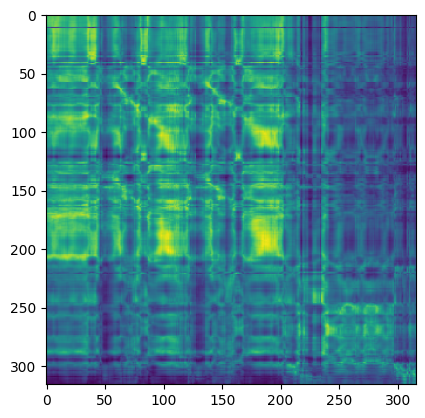

In [36]:
# visualize the similarity
plt.imshow(similarity.cpu().numpy())

# there is an apparent diagonal in the figure
# we can select matched video snippets with this diagonal

In [37]:
@torch.no_grad()
def select_piece_from_similarity(similarity):
    m, n = similarity.size()
    row_indices = torch.arange(m).view(-1, 1).expand(m, n).to(similarity)
    col_indices = torch.arange(n).view(1, -1).expand(m, n).to(similarity)
    diagonal_indices = similarity.size(0) - 1 - row_indices + col_indices
    unique_diagonal_indices, inverse_indices = torch.unique(
        diagonal_indices, return_inverse=True)

    diagonal_sums_list = torch.zeros(
        unique_diagonal_indices.size(0),
        dtype=similarity.dtype,
        device=similarity.device)
    diagonal_sums_list.scatter_add_(0, inverse_indices.view(-1),
                                    similarity.view(-1))
    diagonal_sums_list[:min(m, n) // 4] = 0
    diagonal_sums_list[-min(m, n) // 4:] = 0
    index = diagonal_sums_list.argmax().item()

    similarity_smooth = torch.nn.functional.max_pool2d(
        similarity[None], (1, 11), stride=(1, 1), padding=(0, 5))[0]
    similarity_vec = similarity_smooth.diagonal(offset=index - m +
                                                1).cpu().numpy()

    stu_start = max(0, m - 1 - index)
    tch_start = max(0, index - m + 1)

    return dict(
        stu_start=stu_start,
        tch_start=tch_start,
        length=len(similarity_vec),
        similarity=similarity_vec)

In [38]:
matched_piece_info = select_piece_from_similarity(similarity)

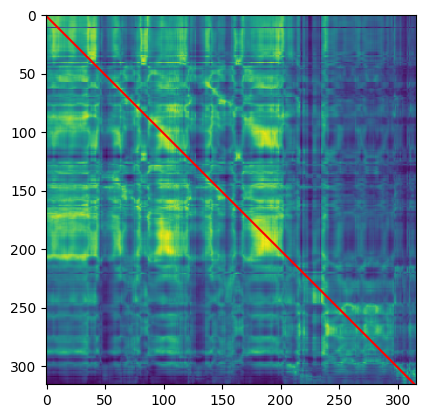

In [39]:
plt.imshow(similarity.cpu().numpy())
plt.plot((matched_piece_info['tch_start'],
          matched_piece_info['tch_start']+matched_piece_info['length']-1),
         (matched_piece_info['stu_start'],
          matched_piece_info['stu_start']+matched_piece_info['length']-1), 'r')

### Generate Output Video

In [40]:
from typing import Tuple

def resize_image_to_fixed_height(image: np.ndarray,
                                 fixed_height: int) -> np.ndarray:
    """Resizes an input image to a specified fixed height while maintaining its
    aspect ratio.

    Args:
        image (np.ndarray): Input image as a numpy array [H, W, C]
        fixed_height (int): Desired fixed height of the output image.

    Returns:
        Resized image as a numpy array (fixed_height, new_width, channels).
    """
    original_height, original_width = image.shape[:2]

    scale_ratio = fixed_height / original_height
    new_width = int(original_width * scale_ratio)
    resized_image = cv2.resize(image, (new_width, fixed_height))

    return resized_image

def blend_images(img1: np.ndarray,
                 img2: np.ndarray,
                 blend_ratios: Tuple[float, float] = (1, 1)) -> np.ndarray:
    """Blends two input images with specified blend ratios.

    Args:
        img1 (np.ndarray): First input image as a numpy array [H, W, C].
        img2 (np.ndarray): Second input image as a numpy array [H, W, C]
        blend_ratios (tuple): A tuple of two floats representing the blend
            ratios for the two input images.

    Returns:
        Blended image as a numpy array [H, W, C]
    """

    def normalize_image(image: np.ndarray) -> np.ndarray:
        if image.dtype == np.uint8:
            return image.astype(np.float32) / 255.0
        return image

    img1 = normalize_image(img1)
    img2 = normalize_image(img2)

    blended_image = img1 * blend_ratios[0] + img2 * blend_ratios[1]
    blended_image = blended_image.clip(min=0, max=1)
    blended_image = (blended_image * 255).astype(np.uint8)

    return blended_image

def get_smoothed_kpt(kpts, index, sigma=5):
    """Smooths keypoints using a Gaussian filter."""
    assert kpts.shape[1] == 17
    assert kpts.shape[2] == 3
    assert sigma % 2 == 1

    num_kpts = len(kpts)

    start_idx = max(0, index - sigma // 2)
    end_idx = min(num_kpts, index + sigma // 2 + 1)

    # Extract a piece of the keypoints array to apply the filter
    piece = kpts[start_idx:end_idx].copy()
    original_kpt = kpts[index]

    # Split the piece into coordinates and scores
    coords, scores = piece[..., :2], piece[..., 2]

    # Calculate the Gaussian ratio for each keypoint
    gaussian_ratio = np.arange(len(scores)) + start_idx - index
    gaussian_ratio = np.exp(-gaussian_ratio**2 / 2)

    # Update scores using the Gaussian ratio
    scores *= gaussian_ratio[:, None]

    # Compute the smoothed coordinates
    smoothed_coords = (coords * scores[..., None]).sum(axis=0) / (
        scores[..., None].sum(axis=0) + 1e-4)

    original_kpt[..., :2] = smoothed_coords

    return original_kpt

In [41]:
score, last_vis_score = 0, 0
video_writer = None
output_file = 'output.mp4'
stu_kpts = student_poses
tch_kpts = teacher_poses

In [42]:
from mmengine.structures import InstanceData

tch_video_reader = VideoReader(teacher_video)
stu_video_reader = VideoReader(student_video)
for _ in range(matched_piece_info['tch_start']):
    _ = next(tch_video_reader)
for _ in range(matched_piece_info['stu_start']):
    _ = next(stu_video_reader)

for i in track_iter_progress(range(matched_piece_info['length'])):
    tch_frame = mmcv.bgr2rgb(next(tch_video_reader))
    stu_frame = mmcv.bgr2rgb(next(stu_video_reader))
    tch_frame = resize_image_to_fixed_height(tch_frame, 300)
    stu_frame = resize_image_to_fixed_height(stu_frame, 300)

    stu_kpt = get_smoothed_kpt(
        stu_kpts, matched_piece_info['stu_start'] + i, 5)
    tch_kpt = get_smoothed_kpt(
        tch_kpts, matched_piece_info['tch_start'] + i, 5)

    # draw pose
    stu_kpt[..., 1] += (300 - 256)
    tch_kpt[..., 0] += (256 - 192)
    tch_kpt[..., 1] += (300 - 256)
    stu_inst = InstanceData(
        keypoints=stu_kpt[None, :, :2],
        keypoint_scores=stu_kpt[None, :, 2])
    tch_inst = InstanceData(
        keypoints=tch_kpt[None, :, :2],
        keypoint_scores=tch_kpt[None, :, 2])

    stu_out_img = pose_estimator.visualizer._draw_instances_kpts(
        np.zeros((300, 256, 3)), stu_inst)
    tch_out_img = pose_estimator.visualizer._draw_instances_kpts(
        np.zeros((300, 256, 3)), tch_inst)
    out_img = blend_images(
        stu_out_img, tch_out_img, blend_ratios=(1, 0.3))

    # draw score
    score_frame = matched_piece_info['similarity'][i]
    score += score_frame * 1000
    if score - last_vis_score > 1500:
        last_vis_score = score
    pose_estimator.visualizer.set_image(out_img)
    pose_estimator.visualizer.draw_texts(
        'score: ', (60, 30),
        font_sizes=15,
        colors=(255, 255, 255),
        vertical_alignments='bottom')
    pose_estimator.visualizer.draw_texts(
        f'{int(last_vis_score)}', (115, 30),
        font_sizes=30 * max(0.4, score_frame),
        colors=(255, 255, 255),
        vertical_alignments='bottom')
    out_img = pose_estimator.visualizer.get_image()

    # concatenate
    concatenated_image = np.hstack((stu_frame, out_img, tch_frame))
    if video_writer is None:
        video_writer = cv2.VideoWriter(output_file,
                                       cv2.VideoWriter_fourcc(*'mp4v'),
                                       30,
                                       (concatenated_image.shape[1],
                                        concatenated_image.shape[0]))
    video_writer.write(mmcv.rgb2bgr(concatenated_image))

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 315/315, 59.3 task/s, elapsed: 5s, ETA:     0s


In [43]:
if video_writer is not None:
    video_writer.release()

---

In [44]:
from moviepy.editor import *
from IPython.display import Image, display

In [ ]:
v_name = '/content/output.mp4'

video = VideoFileClip(v_name)
print(f"{v_name} resolution: {video.size[0]}x{video.size[1]}")

/content/output.mp4 resolution: 424x300


In [48]:
gif_size = (424, 300)

video = VideoFileClip(v_name)
video = video.resize(gif_size)
gif = video.write_gif(f"{v_name.split('.')[0]}.gif", fps=10)

MoviePy - Building file /content/output.gif with imageio.


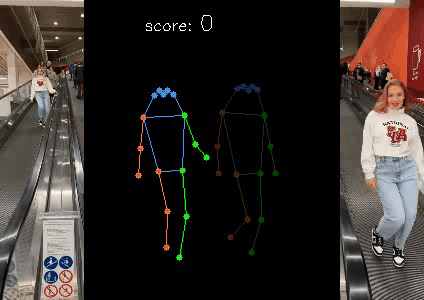

In [ ]:
display(Image(filename='/content/output.gif'))